### https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/

In [1]:
!pwd

/home/nilesh/ner


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import transformers
from transformers import BertForTokenClassification, AdamW
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import get_linear_schedule_with_warmup
from seqeval.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
import json
import seaborn as sns
import os
import sys
os.environ["TFHUB_CACHE_DIR"] = '/data/tfhub_modules'

sys.path.extend(["/home/nilesh/git/tensorflow_experiments/tf2.3/models"])

In [172]:
data = pd.read_csv("./BERT-NER_Hindi/data/ner_dataset.csv", encoding="latin1").fillna(method="ffill")

data.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [173]:
data.shape

(1048576, 4)

# only for hindi

In [10]:
data1 = pd.read_csv("./BERT-NER_Hindi/data/hindi_data.csv",header=0).fillna(method="ffill")
data1.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 47960,अरे,NNS,O
1,Sentence: 47960,सारथी,NNS,O
2,Sentence: 47960,जम्मू,NNS,U-location
3,Sentence: 47960,कैसा,NNS,O
4,Sentence: 47960,मौसम,NNS,O
5,Sentence: 47960,है,NNS,O
6,Sentence: 47960,.,.,O
7,Sentence: 47961,अभी,NNS,U-date
8,Sentence: 47961,दिल्ली,NNS,U-location
9,Sentence: 47961,में,NNS,O


In [11]:
data2=data.append(data1)
data2.tail(10)
data=data2
data.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


### Use this training set Training_hindi_NER1.csv or append the training set with your own data to test.

In [12]:
data3 = pd.read_csv("./BERT-NER_Hindi/data/hinglish_ner_text.csv",header=0).fillna(method="ffill")
data3.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 0,Bahubali,NNS,B-Per
1,Sentence: 0,2,NNS,Other
2,Sentence: 0,ke,NNS,Other
3,Sentence: 0,liye,NNS,Other
4,Sentence: 0,line,NNS,Other
5,Sentence: 0,lag,NNS,Other
6,Sentence: 0,sakte,NNS,Other
7,Sentence: 0,hai,NNS,Other
8,Sentence: 0,desh,NNS,B-Org
9,Sentence: 0,ke,NNS,Other


In [13]:
data3.shape

(68506, 4)

In [220]:
data9=data.append(data3)
data9.tail(10)
data=data9
data.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


# adding Japnese data from bottom

In [22]:
data=Jap_data
data.head(5)

,Sentence #,Word,Tag,POS
0,Sentence: 0,降りるのと同じように、,O,NNS
1,Sentence: 0,デンバー,GPE,NNS
2,Sentence: 0,出入りする、,O,NNS
3,Sentence: 0,フィラデルフィア,GPE,NNS
4,Sentence: 0,ら出て,O,NNS


In [174]:
data10=data.append(Jap_data)
data10.tail(10)
data=data10
data.tail(10)

,Sentence #,Word,POS,Tag
1034,Sentence: 50253,様 の 件 でしょう か,NNS,O
1035,Sentence: 50253,様 の 件 でしょう か,NNS,O
1036,Sentence: 50254,,NNS,O
1037,Sentence: 50254,只見,NNS,B-per
1038,Sentence: 50254,様 です ね ご 担当者 様 は で 一応 ここ を 今 1 回 の 方 に いる ん で...,NNS,O
1039,Sentence: 50254,只見,NNS,B-per
1040,Sentence: 50254,様 を 呼び出す よう な 形 で よろしかったですか ね,NNS,O
1041,Sentence: 50255,現地 担当者 様 へ,NNS,O
1042,Sentence: 50255,只見,NNS,B-per
1043,Sentence: 50255,様 ご 連絡 いただけれ ば と 思い ます,NNS,O


In [23]:
data['Tag'].value_counts()

O           5372
CARDINAL     674
PERSON       633
GPE          421
ORG          413
TIME         395
MONEY        250
URL          198
DATE         138
EMAIL         54
PERCENT       28
Name: Tag, dtype: int64

In [249]:
data.to_csv("/home/nilesh/ner/BERT-NER_Hindi/data/Training_jap_NER.csv", encoding="utf-8") 

In [24]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


In [25]:
getter = SentenceGetter(data)
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]


['降りるのと同じように、',
 'デンバー',
 '出入りする、',
 'フィラデルフィア',
 'ら出て',
 'デンバー',
 '入る、両方の方法で車椅子が必要になります。そして、あなたがこれに気付くことができるかどうかはわかりませんが、私はプラットフォームに立つことができません、そして彼らは私をかなり通過させ、',
 'デンバー',
 '出発し',
 'フィラデルフィア',
 '到着、つまり、それは',
 '20分',
 '間続いていました。ばかげていた。']

In [26]:
labels = [[s[2] for s in sentence] for sentence in getter.sentences]
print(labels[0])


['O', 'GPE', 'O', 'GPE', 'O', 'GPE', 'O', 'GPE', 'O', 'GPE', 'O', 'TIME', 'O']


In [27]:
tag_values = list(set(data["Tag"].values))
print(tag_values)
tag_values.append("PAD")
print(tag_values)
tag2idx = {t: i for i, t in enumerate(tag_values)}
print(tag2idx)

['CARDINAL', 'GPE', 'DATE', 'ORG', 'O', 'TIME', 'EMAIL', 'PERSON', 'URL', 'PERCENT', 'MONEY']
['CARDINAL', 'GPE', 'DATE', 'ORG', 'O', 'TIME', 'EMAIL', 'PERSON', 'URL', 'PERCENT', 'MONEY', 'PAD']
{'CARDINAL': 0, 'GPE': 1, 'DATE': 2, 'ORG': 3, 'O': 4, 'TIME': 5, 'EMAIL': 6, 'PERSON': 7, 'URL': 8, 'PERCENT': 9, 'MONEY': 10, 'PAD': 11}


In [28]:
pd.unique(data['Tag'])

array(['O', 'GPE', 'TIME', 'MONEY', 'PERSON', 'CARDINAL', 'ORG', 'DATE',
       'URL', 'PERCENT', 'EMAIL'], dtype=object)

In [29]:

torch.__version__


'1.7.1'

In [30]:
MAX_LEN = 75
bs = 32


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()


In [32]:
torch.cuda.get_device_name(0)


'NVIDIA Tesla V100-SXM2-16GB'

In [103]:
args_do_lower_case='False'
args_max_seq_length=128
num_labels=len(tag2idx)
args_bert_model='cl-tohoku/bert-base-japanese-whole-word-masking' 

In [70]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained(args_bert_model)


In [262]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)


In [71]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [72]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]


In [73]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]


In [74]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")


In [75]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")


In [76]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]


In [77]:
print(attention_masks)

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [78]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)


In [79]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)


In [80]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


In [81]:


transformers.__version__


'4.5.1'

In [82]:

model = AutoModelForMaskedLM.from_pretrained(args_bert_model,num_labels=num_labels,
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [385]:
args_bert_model='bert-base-multilingual-cased'

model = BertForTokenClassification.from_pretrained(
    args_bert_model,
    num_labels=num_labels,
    output_attentions = False,
    output_hidden_states = False
)


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

In [83]:
model.cuda()


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [84]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


In [85]:


epochs = 10
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [86]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    #print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Average train loss: 1.4867601372161001


Epoch:  10%|█         | 1/10 [00:14<02:09, 14.40s/it]

Validation loss: 0.3773571054140727
Validation Accuracy: 0.8415997706422018

Average train loss: 0.2507267207047849


Epoch:  20%|██        | 2/10 [00:28<01:55, 14.40s/it]

Validation loss: 0.2825215607881546
Validation Accuracy: 0.8372993119266054

Average train loss: 0.15028254172044261


Epoch:  30%|███       | 3/10 [00:43<01:40, 14.39s/it]

Validation loss: 0.2515881434082985
Validation Accuracy: 0.8393061926605505

Average train loss: 0.09886461253857838


Epoch:  40%|████      | 4/10 [00:57<01:26, 14.42s/it]

Validation loss: 0.2325584472467502
Validation Accuracy: 0.8821674311926605

Average train loss: 0.053625222111015385


Epoch:  50%|█████     | 5/10 [01:11<01:11, 14.39s/it]

Validation loss: 0.2645313674584031
Validation Accuracy: 0.8856077981651376

Average train loss: 0.03697126373903439


Epoch:  60%|██████    | 6/10 [01:26<00:57, 14.36s/it]

Validation loss: 0.30432348387936753
Validation Accuracy: 0.8821674311926605

Average train loss: 0.027911847984453418


Epoch:  70%|███████   | 7/10 [01:40<00:42, 14.32s/it]

Validation loss: 0.30739440613736707
Validation Accuracy: 0.8811639908256881

Average train loss: 0.018951407273493287


Epoch:  80%|████████  | 8/10 [01:54<00:28, 14.32s/it]

Validation loss: 0.2739228961678843
Validation Accuracy: 0.8768635321100917

Average train loss: 0.014828226274265995


Epoch:  90%|█████████ | 9/10 [02:08<00:14, 14.27s/it]

Validation loss: 0.28230366700639326
Validation Accuracy: 0.8800172018348624

Average train loss: 0.012233305045948276


Epoch: 100%|██████████| 10/10 [02:23<00:00, 14.32s/it]

Validation loss: 0.3090176455055674
Validation Accuracy: 0.8837442660550459



In [87]:
from sklearn.metrics import classification_report
y_true = valid_tags
y_pred = pred_tags
target_names = list(set(valid_tags))
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    CARDINAL       1.00      0.19      0.32       148
        DATE       0.89      0.47      0.61       178
         GPE       1.00      1.00      1.00        15
         ORG       0.66      0.15      0.24       128
           O       0.80      0.92      0.86        13
        TIME       0.90      0.98      0.93      5818
       EMAIL       0.97      0.70      0.81       203
         URL       0.56      0.41      0.47       414
       MONEY       0.00      0.00      0.00        15
      PERSON       1.00      0.48      0.65        44

    accuracy                           0.88      6976
   macro avg       0.78      0.53      0.59      6976
weighted avg       0.88      0.88      0.87      6976



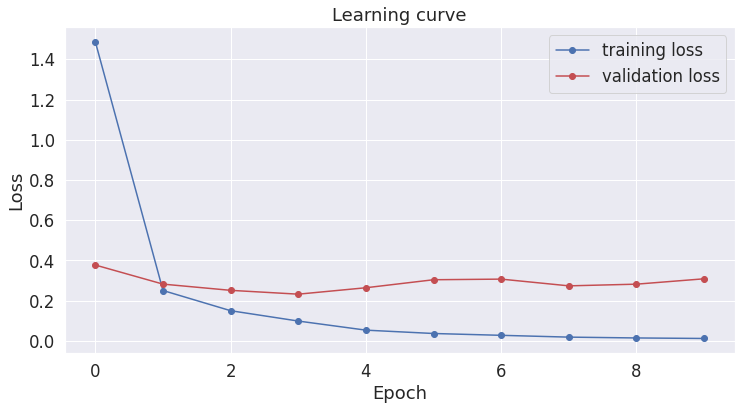

In [88]:


# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [89]:
class Ner:

    def __init__(self,model_dir: str):
        self.model , self.tokenizer, self.model_config = self.load_model(model_dir)
        self.label_map = self.model_config["label_map"]
        self.max_seq_length = self.model_config["max_seq_length"]
        self.label_map = {int(v):k for k,v in self.label_map.items()}
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.model = self.model.to(self.device)
        self.model.eval()

    def load_model(self, model_dir: str, model_config: str = "model_config.json"):
        model_config = os.path.join(model_dir,model_config)
        model_config = json.load(open(model_config))
        model = BertForTokenClassification.from_pretrained(model_dir)
        tokenizer = BertTokenizer.from_pretrained(model_dir, do_lower_case=model_config["do_lower"])
        return model, tokenizer, model_config

    def tokenize(self, text: str):
        """ tokenize input"""
        tokenized_sentence = self.tokenizer.encode(text)
        return tokenized_sentence

    def preprocess(self, text: str):
       
        """ preprocess """
        tokenized_sentence = self.tokenize(text)
        input_ids = torch.tensor([tokenized_sentence])
        input_ids = input_ids.to(self.device)
        return input_ids

    def predict(self, text: str):
        input_ids = self.preprocess(text)
        with torch.no_grad():
            output = self.model(input_ids)
        label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
        
        tokens = self.tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
        new_tokens, new_labels = [], []
        for token, label_idx in zip(tokens, label_indices[0]):
            if token.startswith("##"):
                new_tokens[-1] = new_tokens[-1] + token[2:]
            else:
                new_labels.append(self.label_map[label_idx])
                new_tokens.append(token)
        output = [{"word":token,"tag":label} for token, label in zip(new_tokens, new_labels)]
        return output
    
    def get_turn_output(self, input_list):
        lst_tuple = [self.predict(x) for x in input_list]
        lst_tuple1=[]
        for i in range(len(lst_tuple)):
            lst_tuple_1= [(x['tag']!='O') for x in lst_tuple[i]]
            arr = np.array(lst_tuple[i])
            lst_tuple1.append(arr[lst_tuple_1])
        output = [{"Sentence":token,"Entity":label} for token, label in zip(amount, lst_tuple1)]
        return output 


# examples testing manually

In [1]:
#test_sentence = """Mr. Trump’s tweets began just moments after a Fox News report by Mike Tobin, a reporter for the network, about protests in Minnesota and elsewhere. """
test_sentence = u" के विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका ने संयुक्त राष्ट्र के प्रतिबंधों को इराकी नागरिकों के लिए कम हानिकारक बनाने के लिए कहा है"

In [106]:
test_sentence = 'आज विदेश मंत्री ने अमरीका के उस प्रस्ताव का मजाक उड़ाया है , जिसमें अमरीका'

In [143]:
test_sentence = ' My name is Marquez 00:00:00. How can I help you? Hello? Hello, maam. If youre on the other line, this is Marquez from Frontier Airlines. How can I help you today? Hello, maam. My name is Marquez from Frontier Airlines. How can I help you today? Can you not hear me?'

In [58]:
test_sentence = '私の名前は<AGN>マルケス</AGN> 00:00:00です。どんな御用でしょうか？もしもし？こんにちはマダム。他の路線にいる場合、これは<ORG>フロンティア航空</ORG>の<AGN>マルケス</AGN>です。今日はなんか手伝うことある？こんにちはマダム。私の名前は<ORG>フロンティア航空</ORG>の<AGN>マルケス</AGN>です。今日はなんか手伝うことある？聞こえませんか？'

In [95]:
test_sentence = 'えー 青森県 東 えー 津軽 郡 平内町'

In [96]:
tokenized_sentence = tokenizer.encode(test_sentence)
print(tokenized_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()


[2, 1723, 28451, 4576, 149, 122, 1723, 28451, 12554, 417, 223, 28610, 252, 3]


In [97]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)


In [98]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)
output = [{"word":token,"tag":label} for token, label in zip(new_tokens, new_labels)]

In [99]:
lst_tuple=output

lst_tuple_1= [(x['tag']!='O') for x in lst_tuple]
arr = np.array(lst_tuple)
print("input sentence:",test_sentence,"Entity:",arr[lst_tuple_1])

input sentence: えー 青森県 東 えー 津軽 郡 平内町 Entity: []


In [358]:
lst_tuple=output

lst_tuple_1= [(x['tag']!='O') for x in lst_tuple]
arr = np.array(lst_tuple)
print("input sentence:",test_sentence,"Entity:",arr[lst_tuple_1])

input sentence: agent: えー 青森県 東 えー 津軽 郡 平内町 4 の 17 で ござい ます ね はい 承知 いたし まし た 建物 の 名前 も いただけ ませ ん でしょう か えー マンション名 が ドリーム 沼館  Entity: [{'word': '青', 'tag': 'GPE'} {'word': '森', 'tag': 'GPE'}
 {'word': '県', 'tag': 'GPE'} {'word': '東', 'tag': 'GPE'}
 {'word': '津', 'tag': 'GPE'} {'word': '軽', 'tag': 'GPE'}
 {'word': '郡', 'tag': 'GPE'} {'word': '平', 'tag': 'GPE'}
 {'word': '内', 'tag': 'GPE'} {'word': '町', 'tag': 'GPE'}
 {'word': '4', 'tag': 'CARDINAL'} {'word': '17', 'tag': 'CARDINAL'}
 {'word': 'ドリーム', 'tag': 'PERSON'}]


## Saving the model and testing against set note:make sure to change the path

In [104]:
# Save a trained model and the associated configuration
final_model_path='/data/pymodels/ner_multilingual_bert'
final_versioned_model_path = os.path.join(final_model_path,'5')
model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
model_to_save.save_pretrained(final_versioned_model_path)
tokenizer.save_pretrained(final_versioned_model_path)
#label_map = {i : label for i, label in enumerate(label_list,1)}
model_config = {"bert_model":args_bert_model,"do_lower":args_do_lower_case,"max_seq_length":args_max_seq_length,"num_labels":num_labels,"label_map":tag2idx}
json.dump(model_config,open(os.path.join(final_versioned_model_path,"model_config.json"),"w"))

### load a stored model

In [112]:
#import libraries for loading the model
from transformers import BertForTokenClassification
from transformers import BertTokenizer, BertConfig
import os,json
import torch
import numpy as np

### run below if NER function not working

In [105]:
test_sentence = 'ワ 年 ぶり とめ です 。 あの ショル ルフレ プロボ", "Agent : さかた 押して くれる でしょう な 。 アワ セル 者 に 浮かべば 直 悦'

In [106]:
class Ner:

    def __init__(self,model_dir: str):
        self.model , self.tokenizer, self.model_config = self.load_model(model_dir)
        self.label_map = self.model_config["label_map"]
        self.max_seq_length = self.model_config["max_seq_length"]
        self.label_map = {int(v):k for k,v in self.label_map.items()}
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.model = self.model.to(self.device)
        self.model.eval()

    def load_model(self, model_dir: str, model_config: str = "model_config.json"):
        model_config = os.path.join(model_dir,model_config)
        model_config = json.load(open(model_config))
        model = BertForTokenClassification.from_pretrained(model_dir)
        tokenizer = BertTokenizer.from_pretrained(model_dir, do_lower_case=model_config["do_lower"])
        return model, tokenizer, model_config

    def tokenize(self, text: str):
        """ tokenize input"""
        tokenized_sentence = self.tokenizer.encode(text)
        return tokenized_sentence

    def preprocess(self, text: str):
       
        """ preprocess """
        tokenized_sentence = self.tokenize(text)
        input_ids = torch.tensor([tokenized_sentence])
        input_ids = input_ids.to(self.device)
        return input_ids

    def predict(self, text: str):
        input_ids = self.preprocess(text)
        with torch.no_grad():
            output = self.model(input_ids)
        label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
        
        tokens = self.tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
        new_tokens, new_labels = [], []
        for token, label_idx in zip(tokens, label_indices[0]):
            if token.startswith("##"):
                new_tokens[-1] = new_tokens[-1] + token[2:]
            else:
                new_labels.append(self.label_map[label_idx])
                new_tokens.append(token)
        output = [{"word":token,"tag":label} for token, label in zip(new_tokens, new_labels)]
        return output
    
    def get_turn_output(self, input_list):
        lst_tuple = [self.predict(x) for x in input_list]
        lst_tuple1=[]
        for i in range(len(lst_tuple)):
            lst_tuple_1= [(x['tag']!='O') for x in lst_tuple[i]]
            arr = np.array(lst_tuple[i])
            lst_tuple1.append(arr[lst_tuple_1])
        output = [{"Sentence":token,"Entity":label} for token, label in zip(amount, lst_tuple1)]
        return output 



In [107]:
#version 3 has iteration 3 only on japnese data
#version 4 has iteration 10 only on japnese data
#version 5 has Hugging face
final_versioned_model_path='/data/pymodels/ner_multilingual_bert/5/'
model = Ner(final_versioned_model_path)

Some weights of the model checkpoint at /data/pymodels/ner_multilingual_bert/5/ were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at /data/pymodels/ne

In [108]:
check=model.predict(test_sentence)

In [109]:
print(check)

[{'word': '[CLS]', 'tag': 'MONEY'}, {'word': 'ワ', 'tag': 'MONEY'}, {'word': '年', 'tag': 'MONEY'}, {'word': 'ふり', 'tag': 'MONEY'}, {'word': 'とめ', 'tag': 'TIME'}, {'word': 'てす', 'tag': 'MONEY'}, {'word': '。', 'tag': 'MONEY'}, {'word': 'あの', 'tag': 'MONEY'}, {'word': 'ショル', 'tag': 'MONEY'}, {'word': 'ルフレ', 'tag': 'GPE'}, {'word': 'フロホ', 'tag': 'MONEY'}, {'word': '"', 'tag': 'TIME'}, {'word': ',', 'tag': 'TIME'}, {'word': '"', 'tag': 'TIME'}, {'word': 'agent', 'tag': 'MONEY'}, {'word': ':', 'tag': 'EMAIL'}, {'word': 'さかた', 'tag': 'MONEY'}, {'word': '押', 'tag': 'DATE'}, {'word': 'して', 'tag': 'MONEY'}, {'word': 'くれる', 'tag': 'MONEY'}, {'word': 'てしょう', 'tag': 'MONEY'}, {'word': 'な', 'tag': 'MONEY'}, {'word': '。', 'tag': 'MONEY'}, {'word': 'アワ', 'tag': 'MONEY'}, {'word': 'セル', 'tag': 'MONEY'}, {'word': '者', 'tag': 'TIME'}, {'word': 'に', 'tag': 'MONEY'}, {'word': '浮', 'tag': 'MONEY'}, {'word': 'かへは', 'tag': 'TIME'}, {'word': '直', 'tag': 'MONEY'}, {'word': '悦', 'tag': 'TIME'}, {'word': '[SEP]', 

In [110]:
ts="agent: お 乗り換え を ご 検討 し て いらっしゃる お客様 の お 電話 番号 と お 名前 を フルネーム で お 聞か せ 頂け ます でしょう か はい ええ 電話 番号 が 08044572225 はい 名前 が ええ 名前 が 村木 くに ひと と いい ます はい かしこまり まし た 復唱 いたし ます お 電話 番号 が 08044572225 で お 名前 が 村木 くに ひと 様 で よろしい でしょう か "
#ts='キョウトフ, キョウタンゴシ, タンゴチョウイエノタニ, 248-1005'

In [111]:
lst_tuple=[model.predict(ts)]

In [112]:
lst_tuple1=[]
for i in range(len(lst_tuple)):
    lst_tuple_1= [(x['tag']!='O') for x in lst_tuple[i]]
    arr = np.array(lst_tuple[i])
    lst_tuple1.append(arr[lst_tuple_1])

In [113]:
print("Sentence:",ts,"\n","Entity:",lst_tuple1)

Sentence: agent: お 乗り換え を ご 検討 し て いらっしゃる お客様 の お 電話 番号 と お 名前 を フルネーム で お 聞か せ 頂け ます でしょう か はい ええ 電話 番号 が 08044572225 はい 名前 が ええ 名前 が 村木 くに ひと と いい ます はい かしこまり まし た 復唱 いたし ます お 電話 番号 が 08044572225 で お 名前 が 村木 くに ひと 様 で よろしい でしょう か  
 Entity: [array([{'word': '[CLS]', 'tag': 'TIME'}, {'word': 'agent', 'tag': 'TIME'},
       {'word': ':', 'tag': 'TIME'}, {'word': 'お', 'tag': 'TIME'},
       {'word': '乗', 'tag': 'TIME'}, {'word': 'り', 'tag': 'MONEY'},
       {'word': '換', 'tag': 'TIME'}, {'word': 'え', 'tag': 'TIME'},
       {'word': 'を', 'tag': 'GPE'}, {'word': 'こ', 'tag': 'MONEY'},
       {'word': '検', 'tag': 'MONEY'}, {'word': '討', 'tag': 'TIME'},
       {'word': 'し', 'tag': 'TIME'}, {'word': 'て', 'tag': 'TIME'},
       {'word': 'いらっしゃる', 'tag': 'TIME'}, {'word': 'お', 'tag': 'TIME'},
       {'word': '客', 'tag': 'TIME'}, {'word': '様', 'tag': 'MONEY'},
       {'word': 'の', 'tag': 'TIME'}, {'word': 'お', 'tag': 'TIME'},
       {'word': '電', 'tag': 'MONEY'}, {'word': '話', 'tag': 'MONEY'},
 

### testing

In [291]:
amount=["Agent : そこなんですが 現在 1610円で続けていただいていた 今回の更新の時期を迎えていた ガン保険はいかがでいたしますか 新しい保険の保障が 開始しておやめになりますかその方がいいですね いいから言ってくれてるわけですよね", "Customer : 申し訳ございません 自動的にはできないんですね<babble>今の保険は更新となりますので 12月からは 3040円となりますけれども この期間の保険の重複は大丈夫ですかそうなんですか なるほどですね 保険の重複は大丈夫です", "Agent : au でももちろん wifi はありますので 4ギガでしたら 4000円程の維持費 ひなんですが ポケット wifi を持って 一番少ないギガにするという方法もあります そうすると出先で快適にご利用いただけるメリットもありますので Customer: あーなるほどね そういうことですね", "Customer : データ max にすると維持費は上がりますが 最初に 1年間は 1100円のお値引きが可能です 通常の 4ギガ のデータ max と同じ料金になりますね", "Agent : はいありがとうございます では月々の保険料が 5552円で表示してあるこの件でございますね 何かご不明点ございましたでしょうか", "Customer : そうなんですね ありがとうございます 一応払い込み免除をお付けした場合 1ヶ月分の保険料が お手元には 9908円 2ヶ月分の 19816円となっていると思うのですが", "Agent : 12750円がお乗り換えの際にかかる費用となりますあーなるほど", "Customer : 手数料と解約料金あわせて 14750円ですね 大変失礼いたしました", "Agent : お客様が当選しましたので10000円分のAmazonギフトカードをプレゼントいたします。おめでとうございます！", "Customer : 去年まで水道代として1000円を払ってたんですけど今年から2000円になっちゃたんですね。なぜ上がったんですか？", "Agent : 例えばですね 簡単定期保険というのがあるんですけれども こちらですと 例えば 65歳で女性の方で 5404円というのがあるんですねで それが 10年ごとにいくらになるんですか", "Customer : 今妻が 100万円終身保険に入ろうとしてるんですよ そうですね まあ この 12月のご契約", "Agent : 2000円とか 3000円しか変わらなかったらその方がいいですよね そうしてください なので 25日に振り込む予定にするので 今週中にそれをやってもらえたら手続きはokですよねはいかしこしました 間に合うようにとご希望されるということですね"]

In [20]:
date_email=["Agent : 予約が3月15日の午後の5:00時でよろしでっしょかはいお願いします", "Customer : 車の購入日わかりますか車を購入じたのは今2019年9月12日です", "Agent : すぐ作ってくれたら30日が誕生日だから29日でも振り込みはいけるでしょ 確認できないの はい 一応振り込みの期限がですね 6月の 29日までに 振り込みをしていただく", "Customer : あの契約いつされたのかわかりますか はい2019年12月9日です", "Agent : 恐れ入りますが2021年9月13日までお支払い可能ですか今はわからないですが", "Customer : この前2021年3月8日に電話いただきましたが今でも問題が発生していますCustomer:ええまあそうですね", "Agent : その宅配便ですけどいつ届きますか 恐れ入りますが2021年6月18日に届くと思います", "Customer : あの2021年7月8日の予約がありましたがキャンセル したいですわからいました", "Agent : 事故はいつの出来事ですか あの2017年1月12日の出来事です", "Customer : あとは私のメールアドレスの情報も持っていますよね はいございますK.samejima＠yahoo.co.jpの情報です", "Agent : ご本人確認のためメールアドレスを教えていたでけますか Kusakabe.ryu@softbank.ne.jpです", "Customer : メールアドレスで調べられますか はいできます じゃhajimerina_777@yahoo.co.jpで", "Agent : 私のメールアドレスですか はいお客様のメールアドレスが必要になります わかりましたメールアドレスはKanata.Takenoko＠softbank.ne.jp", "Customer : Kuki.elephanto@yahoo.co.jpにつながったアカウントがないだと さよでございますもしわけございません", "Agent : 最後にログインしたアカウントがわかりますかはいChokoretto_brown@yahoo.co.jpで間違いないです", "Customer : えとこちらはHaruhiko.Hinata＠softbank.ne.jpというメールアドレからメールを送りましたが映らない方が可笑しいですもしわけありませんもう一度確認してみます", "Agent : 資料を送りますメールアドレスを教えていただけますか はいasoreore@yahoo.co.jpです", "Customer : 恐れ入りますがお客様が今お使いのメールアドレスを教えていただけますか もちろんですhidama.tamaya@yahoo.co.jpですよ"]


In [ ]:
email_only=["Agent : Emilyjonesdesigner @ gmail？","Customer : ええ、emilyjonesdesigner @ gmail.com。","Agent : aol.comで。","Customer : はい。Daniel.Pacific @ cummins、CUMMINS.comです。","Agent : 最後の部分がCUMMINS.comであることを確認するためだけですか？","Customer : だから私はあなたに1Fの座席を事前に割り当てることができました。そして、私がちょうどdkconnor@comcast.netにあなたに送ったその電子メールは参照になります。","Agent : ああ、大丈夫。amhunter、HUNTER、61 @ gmail.comです。","Customer : はい。ラビー。わかりました、labby5 @ comcast.net。","Agent : labby5 @の後、atの後の単語は何ですか？","Customer : Comcast。","Agent : ドットネット？","Customer : ドットネット。","Agent : ありがとうございました。どうぞよろしくお願いいたします。ありがとうございました。（沈黙）それで、ここをチェックすると、これは第三者から作られました。連絡先情報を更新して、出発時刻の24時間。前にウェブサイトでチェックインできるようにすることもできます。一瞬。あなたのメールアドレスはvfrb@hotmail.comですか？","Customer :  。ありがとうございました。 ありがとうございます。 なので、すでに です。ナルニア国物語から を送信しました。正確なemail.comが必要です。 はオンラインになります。心配ない。デボラ、他に何かお手伝いできることはありますか？さて、素晴らしい。 にお電話いただきありがとうございます。お電話ありがとうございます。バイバイ。 人々は、避けられないと言います。人々はそれを言います。私は に精通しています。","Agent : メールをもう一度明確にするために、echoのE、you42 @ hotmail.comです。これで、次のコピーを送信できます-","Customer : はい、どうぞ。座席の再割り当てが完了し、予約に感情的なサポート動物を追加しました。確認メールをお送りしますので、登録されているメールアドレスを確認させていただきます。tina@leafbuyer.comですか？","Agent : はい。ああはい、お願いします。ピクシー、PIXIEMO-M143 @ yahoo.comです。","Customer : V- Sはサムのように、Pはピーターのように、I、Dは犬のように、AHLはyahooo.comにあります。","Agent : つまり、yahoo.comのVictorとあなたの最後の名前Spidahlのようなです。","Customer : ここにファイルがありますが、これはまだSgbecker21@yahoo.comですか？","Agent : ええ、それは私の最後の名前です、それはStocker.Antonio@gmail.comです。","Customer : わかりました。ありがとうございます。メールアドレスと電話番号を読み返してみましょう。あなたのメールアドレスはStocker.antonio @ gmail.comです。そしてあなたの電話番号は（615）556-5369です。","Agent : ASHLEYCINKER13@gmail.com","Customer : ASHLEYCINKER13@gmail.com。さて、ちょっと待ってください。お送りします。","Agent : はい。だから私は今この変更を処理し、talkturic @ gmail.comにそれを見ることができるようにあなたにメールを送りますか？","Customer : そしてあなたのメールアドレス、それは17tface6to0@gmail.comでしょ？","Agent : Berges. Okay. @ gmail.com？これを送信するのは良いメールですか？","Customer : わかりました。確認したいのですが、メールアドレスはAで姓、comcast.netのです。これはまだアクティブですか？","Agent : わかりました、それで...私はあなたの予約にあなたの介助動物をすでに追加しました、そして私はあなたに確認の電子メールを送ります、わかりました、emorenocd @ gmail.com。","Customer : 大丈夫。これについて確認メールをお送りします。メールアドレスはbryce@codeofcrossfit.comですか？","Agent : そして、メールはttgreenwood@gmail.comに送信されますね。","Customer : それでは大丈夫です。このサービス、本日リクエストされた追加の特別サービスを確認するメールを送信し、登録されているアドレスに送信します。Dzack8@gmail.com。","Agent : さて、マダム、ファイルにあるメールを確認するだけで、grippinggarrett @ gmail.com、正しいですか？","Customer : 私はのようにJです... julierowekameROWEKAME ... @ yahoo.com。","Agent : 大丈夫。そして、これはあなたのメールですか？gofishernet@yahoo.comがあります。","Customer : dgheinz57@yahoo.com。","Agent : さて、私がここに持っているメールアドレスはkayhy.greene54@gmail.comです。","Customer : いいえ、それが理由です。kathy.greene54と表示されます。","Agent : 私の生年月日は1-31-1933で、メールアドレスはJliddle8@yahoo.comです。","Customer : cccのはずです、いや、ごめんなさい。j.fonda@gmail.comです","Agent : 341@hotsale.com。","Customer : さて、メールが送信されました。可能であれば、メールを確認するか、追加した手荷物が使用したカードにすでに返金されていることをレイチェルに伝えてみてください。ここのメールアドレスはレイチェルの名前です。racheljgray@yahoo.comですよね？","Agent : DはDavidのように、SはSamのように、Uは傘のようにE、象、R、Robert、O、58723。","Customer : はい、マダム、ここに登録されているメールアドレスはDsuero58723@gmail.comなので、メールアドレスをお聞きしてもよろしいですか。","Agent : それは私のボーイフレンドです、彼が何もチェックしないので、なぜ私が彼を連絡先番号として入れたのか分かりません。彼は明らかに私にコピーを送ってくれませんでした。だからここで、私のものは象のようなE、トムのようなT、I、イタリア、E、象、L、ラリー、B、男の子、S、サンディ@ aol.comです。","Customer : DはDavidのように、SはSamのように、Uは傘のように、E、象、R、Robert、O、58723 @ gmail.com。","Agent : はいマダム。ここに登録されているメールアドレスはdsuero58723@gmail.comですので、メールアドレスをお伺いしてもよろしいでしょうか。","Customer : I、イタリア、E、象L、ラリー、B、男の子S、サンディ、@ aol.com。","Agent : 確認させていただきますが、Jack、Capraの 13のようにComcast.net、ここにあなたのメールアドレスはJですか？","Customer : 承知しました。おそらくjc118@aol.comでしょう。","Agent : 承知しました。おそらくjc118@aol.comでしょう。。それはファイルにあるものです。","Customer : 申し訳ありません。はい。ここに登録されているメールアドレスを明確にするために、cameron10806 @ gmail.comですよね？","Agent : 辛抱強くお待ちいただき、ありがとうございます。これがあなたのメールアドレスであるかどうかを確認させてください  freeforme@gmail.com？","Customer : ちょっと見てみましょう。ティファニー、あなたのメールは  @ gmail.comになりますか？","Agent : 一瞬。ティファニー、あなたのメールアドレスはJosh ... josiehallec@gmail.comですか？","Customer : 大丈夫。だから、確認メールでお送りします。だから、ここであなたのメールアドレスを確認するだけです。それはOlivia、次にROX、そしてBlackのGmail dotcomです。そうですか？","Agent : 大丈夫。確認メールをお送りします。だからここであなたのメールアドレスを確認するだけです。それはOlivia、次にrox、そしてBlackのGmail dotcomです。そうですか？","Customer : それで、もう一度確認するために、メールアドレスはOlivia、次にrox、そしてBlackのGmail dotcomですか？","Agent : Markandsherry ...それは私の確認にあるはずです。スーザン、HERRY、markandsherry @ comcast.netのようにMARKANDSです。","Customer : さて、私の電話番号は（765）228-5870で、メールアドレスはwindhomes1955@gmail.comです。","Agent : 念のため、メールアドレスはGrace_Ardoso@yahoo.comです。あれは正しいですか？","Customer : daleweld@msn.comです","Agent : 私はここで尋ねたので、ここに行きます。私はすでにここにサービスを追加しました。私はあなたにメールを送信しました。メールはzebraoneのYahoodotcomのものです。あなたが私に電話をしている間、私たちが確信できるように、あなたは電子メールにアクセスできますか？","Customer : かしこまりました。42@hotmail.com。","Agent : したがって、もう一度確認するために、メールアドレスはX線のようなOliviaroxであり、次にBlack@gmail.comです。"]

In [21]:
loc=["Agent : はい そうですね 念のためお住まいのご住所お伺いできますでしょうか あーわかりました じゃあ今住んでるとこなので えー 東京都八王子市館町 1 の 5 の 9 です", "Customer : はい 建物などお名前ございますでしょうか マンション名がライオンズマンション 304号室です", "Agent : えー東京都八王子市館町 1 の 5 の 9 でございますね 建物はライオンズマンションですね はい 承知いたしました", "Customer : お待たせをいたしました えっと念のためにご住所も 教えていただけませんでしょうか 私の住んでる住所ですか 青森県東津軽郡平内町沼館 4 の 17 で", "Agent : えー 青森県東 えー 津軽郡平内町 4 の 17 でございますね はい承知いたしました 建物の名前もいただけませんでしょうか えー マンション名が ドリーム沼館", "Customer : はい えードリーム沼館 はい お部屋の番号は えー 404", "Agent : お待たせいたしました 恐れ入ります 念のためにご住所も教えていただけますか 私の住んでいる住所ですか はい そうですね えー 茨城県坂東市生子 3 の 20 で", "Customer : えー 茨城県坂東市生子 3 の 20 でございますね はい 承知いたしました 建物の名前も教えていただけませんでしょうか えっとマンション名が エスポワール高橋", "Agent : はい エスポワール高橋 はい お部屋の番号は えー 101", "Customer : はい ご契約された際のご住所でお願いいたします わかりました であれば今住んでるところなので 神奈川県横須賀市湘南国際村 3 の 10 です", "Agent : 建物などお名前はございますでしょうか ガーデンポート 301 です", "Customer : えー神奈川県横須賀市湘南国際村 3 の 10 でございますね 建物はライオンズマンションですね はい 承知いたしました"]

In [22]:
name=["Agent : ご契約者様のお名前をフルネームでお願いできますでしょうか はい 東野達と申します", "Customer : お客様のお電話番号とお名前をフルネームでお聞かせいただけますでしょうか えー 名前が 岡島誠一と申します", "Agent : お客様 お名前も お名前フルネームとお電話番号を伺えませんか 名前は 田端真紀 で電話番号は 0176632511", "Customer : 電話番号と名前でいい ですか はい えー 電話番号が えー 013781 の 5578 名前は白鳥安男", "Agent : お乗り換えをご検討していらっしゃるお客様のお電話番号とお名前をフルネームでお聞かせ頂けますでしょうか はいええ 電話番号が08044572225  はい 名前が ええ 名前が村木くにひと といいます はい かしこまりました 復唱いたします お電話番号が08044572225 でお名前が村木くにひと様でよろしいでしょうか", "Customer : 恐れ入りますが お客様のご本人確認のため 電話番号と名前でいい はい 電話番号が 0176505314 名前は鮫島京香", "Agent : 恐れ入りますが、お客様のお電話番号とお名前をフルネームでおきかれいただきますでしょうか はい、電話番号が０９０３２３０８６８２、名前が、しむだしょうじと申します。", "Customer : では、恐れ入りますがお客様のお電話番号とお名前をフルネームでお聞かせいただけますでしょうか。 はい、えっ、電話番号が０８０７５８１１２４５。 はい、ありがとうございます。 えっと、名前がやすいつねとしと申します。 はい、かしこまりました。すこし致します。お電話番号が０８０７５８１１２４５、お名前がやすいつねとしさまでよろしいでしょうか。 はい、そうです。", "Agent : あ、あの、鈴木病院ですか。 はい、そうでございます。 妻が入院していて、保険の事で聞きたいことがあります。 お客様のお電話番号とお名前をおきかれいただきますでしょうか。 えっと、名前がたてし木間村と申します。", "Customer : えっと、冷蔵庫が壊れていて、その件で電話したんですけど はい かしこまりました、恐れ入りますが お客様のお名前をお聞かせいただけますでしょうか はい、名前がきみこさかいと申します。"]

In [23]:
org=["Agent : はい えっとですね 料金のところとか詳しくお伺いしたいと思いまして えー今ソフトバンクを使っているんですけど 友人がドコモの方が安いんじゃないってオススメされて", "Customer : かしこまりました はい ご回答ありがとうございます そうしましたら長い間のご利用でしたので ソフトバンクで機種を変える時に少しでもお安くご購入いただけるように クーポンというものをご提案しておりまして", "Agent : ございます はい あとは例えば本日いただいたような月の途中で解約される場合は ソフトバンクの<babble>ご携帯料金が日割り計算となりませんため 満額請求となりまして お乗り換えした月の料金に関しては えーソフトバンクと お乗り換え先で 重複した 請求になるので ご負担としては多くなります", "Customer : <babble>ニュースでドコモさんでお安いプランが出たっていうのは目にしたことがありますね", "Agent : あ 以前 あのう au ではなくてソフトバンク使ってて えー tunetoshi84043@softbank.ne.jp っていうアドレスが あのう appleid がこう設定されていますけど これは大丈夫なんですかね なので このソフトバンクのメールアドレスがそのままなんですよね 一応確認したくて", "Customer : あくまで id なので ソフトバンクのメールアドレスを id としてお使いいただけます 気にな<babble>るようでしたら はい 気になるようでしたら変更していただくことをオススメいたしますが", "Agent : そう ソフトバンクにに変えると月々の料金がかなり安くなるって言われたんですけど それって今のオプションが高いんですかね", "Customer : はい apple の保険のサービスが 979円発生しています", "Agent : apple の保険のサービスは 例えばお電話機をなくされたり 不具合があったときに 保険を使ってお安く修理したり 新しい機種をお届けできたりという特典なんですが それって apple の保険なんですか", "Customer : あー以前ドコモではなくソフトバンク使ってて shimoda55@softbank.ne.jp というアドレスが appleid が設定されていますがこれは 大丈夫なんですか ソフトバンクのメールアドレスがそのままなんですよね あくまで id なので ソフトバンク のメールアドレスを<babble>としてお使いいただけます", "Agent : そう えっとドコモに変えると月々の料金がかなり安くなるって言われてたんですけど それって今のオプションが高いんですかね", "Customer : あとは apple の保険のサービスが 979円発生してるのと あとは消費税 それと紙媒体の請求書をお届けする手数料が 300円かかっていますので あわせて 10000円程かかっているという状況ですね", "Agent : はい apple の保険のサービスが 979円発生しています", "Customer : えー apple の保険のサービスは 例えばお電話機をなくされたり 不具合があったときに保険を使ってお安く修理をしたり 新しい機種をお届けできたりという特典なんですが", "Agent : あ それって apple の保険なんですか", "Customer : えっとですね 料金のところとか詳しくお伺いしたいと思いまして えー今 au を使っているんですけど 友人がソフトバンクの方が安いんじゃないってオススメされていて", "Agent : かしこまりました はい ご回答ありがとうございます そうしましたら 長い間のご利用でしたので au で機種を変える時に少しでもお安くご購入いただけるように クーポンというものをご提案しておりまして", "Customer : はい あとは例えば本日いただいたような 月の途中で解約される場合は au の携帯料金が日割り計算となりませんため 満額請求となりまして お乗り換えした月の料金に関しては au とお乗り換え先で重複した請求になりますのでご負担としては多くなります", "Agent : 私もニュースで ソフトバンクさんでお安いプランが出たっていうのは目にしたことがありますね", "Customer : au で機種変更していただければ 先ほどの解約料もかからないですし e メールアドレスも変わりませんし ご面倒なども少ないかと存じますのでぜひ au とソフトバンクが入っているお店で 両方見ていただいて再度ご検討いただいてからでも遅くないかと思いますので", "Agent : そうですね 大幅な金額は変わらないはずなので であれば au の中で変えていただくほうがご面倒も少ないのかと思いますのでぜひご検討ください"]

In [292]:
amount_output=model.get_turn_output(amount)

In [293]:
import pandas as pd
df=pd.DataFrame(amount_output,columns=['Sentence','Entity'])

In [294]:
print(amount_output)

[{'Sentence': 'Agent : そこなんですが 現在 1610円で続けていただいていた 今回の更新の時期を迎えていた ガン保険はいかがでいたしますか 新しい保険の保障が 開始しておやめになりますかその方がいいですね いいから言ってくれてるわけですよね', 'Entity': array([{'word': '1610', 'tag': 'MONEY'}, {'word': '円', 'tag': 'MONEY'},
       {'word': 'カン', 'tag': 'ORG'}], dtype=object)}, {'Sentence': 'Customer : 申し訳ございません 自動的にはできないんですね<babble>今の保険は更新となりますので 12月からは 3040円となりますけれども この期間の保険の重複は大丈夫ですかそうなんですか なるほどですね 保険の重複は大丈夫です', 'Entity': array([{'word': '12', 'tag': 'DATE'}], dtype=object)}, {'Sentence': 'Agent : au でももちろん wifi はありますので 4ギガでしたら 4000円程の維持費 ひなんですが ポケット wifi を持って 一番少ないギガにするという方法もあります そうすると出先で快適にご利用いただけるメリットもありますので Customer: あーなるほどね そういうことですね', 'Entity': array([{'word': '[CLS]', 'tag': 'EMAIL'},
       {'word': 'agent', 'tag': 'EMAIL'}, {'word': ':', 'tag': 'EMAIL'},
       {'word': 'au', 'tag': 'EMAIL'},
       {'word': '4キカてしたら', 'tag': 'CARDINAL'}], dtype=object)}, {'Sentence': 'Customer : データ max にすると維持費は上がりますが 最初に 1年間は 1100円のお値引きが可能です 通常の 4ギガ のデータ max と同じ料金になりますね', 'Entity': array([{'word'

In [305]:
import pandas as pd

df = pd.read_table('/home/nilesh/ner/jap_test_data/test_set/evaluate_test_format.txt',encoding='utf-8')#,lineterminator='),')

print(df.to_string())

Empty DataFrame
Columns: [[('Agent: はい そうですね 念のためお住まいのご住所お伺いできますでしょうか Customer: あーわかりました じゃあ今住んでるとこなので えー 東京都八王子市館町 1 の 5 の 9 です', [(77, 96, 'GPE')]), ('Agent: はい 建物などお名前ございますでしょうか Customer: マンション名がライオンズマンション 304号室です', [(45, 61, 'GPE')]), ('Agent: えー東京都八王子市館町 1 の 5 の 9 でございますね 建物はライオンズマンションですね はい 承知いたしました', [(9, 28, 'GPE')]), ('Agent: お待たせをいたしました えっと念のためにご住所も 教えていただけませんでしょうか Customer: 私の住んでる住所ですか Customer: 青森県東津軽郡平内町沼館 4 の 17 で', []), ('Agent: えー 青森県東 えー 津軽郡平内町 4 の 17 でございますね はい承知いたしました 建物の名前もいただけませんでしょうか Customer: えー マンション名が ドリーム沼館', []), ('Agent: はい えードリーム沼館 はい お部屋の番号は Customer: えー 404', []), ('Agent: お待たせいたしました 恐れ入ります 念のためにご住所も教えていただけますか Customer: 私の住んでいる住所ですか Agent: はい そうですね Customer: えー 茨城県坂東市生子 3 の 20 で', [(97, 112, 'GPE')]), ('Agent: えー 茨城県坂東市生子 3 の 20 でございますね はい 承知いたしました 建物の名前も教えていただけませんでしょうか Customer: えっとマンション名が エスポワール高橋', [(89, 97, 'GPE')]), ('Agent: はい エスポワール高橋 はい お部屋の番号は Customer: えー 101', []), ('Agent: はい ご契約された際のご住所でお願いいたします Customer: わかりました であれば今住んでるところなので 神奈川県横須賀市湘南国際村 

In [304]:
df_ser[0]#[1]['entities'][0]

True

In [114]:
f = open("/home/nilesh/ner/jap_test_data/test_set/evaluate_test_format.txt")
examples = eval(f.read())

In [115]:
examples[2]

('Agent: えー東京都八王子市館町 1 の 5 の 9 でございますね 建物はライオンズマンションですね はい 承知いたしました',
 [(9, 28, 'GPE')])

In [116]:
import json
import spacy
import numpy as np

output_dir = r'/home/nilesh/ner/jap_test_data/model'
print("Loading from", output_dir)
nlp2 = spacy.load(output_dir)
test_text = "Agent: はい 建物などお名前ございますでしょうか Customer: マンション名がライオンズマンション 304号室です"    # Shinchan, building name, kiichiro toyoda
doc2 = nlp2(test_text)
for ent in doc2.ents:
    print(type(ent),ent.label_, ent.text)

Loading from /home/nilesh/ner/jap_test_data/model
<class 'spacy.tokens.span.Span'> ORG ライオンズ


In [117]:
n=0
for input_, annot in examples:
    print("Iteration:",n)
    print("InputSentence:",input_)
    lst_tuple=[model.predict(input_)]

    lst_tuple1=[]
    for i in range(len(lst_tuple)):
        lst_tuple_1= [(x['tag']!='O') for x in lst_tuple[i]]
        arr = np.array(lst_tuple[i])
        lst_tuple1.append(arr[lst_tuple_1])
    print('JapaneseBert_output:',lst_tuple1)
    #spacy output
    doc2 = nlp2(input_)
    if(len(doc2.ents)==0):
        print('Spacy_output:No output')
    for ent in doc2.ents:
        print('Spacy_output:',ent.label_, ent.text)
        
    if(len(annot)!=0):
        print('Manually Tagged:',annot)
        print('Extracted Entity for manual tagged:',entity_extract(1,input_,annot[0][0],annot[0][1],annot[0][2]))
    else:
        print('Manually no tags available for this sentence')
    print('\n\n')
    n=n+1
    if n>10:
        break

Iteration: 0
InputSentence: Agent: はい そうですね 念のためお住まいのご住所お伺いできますでしょうか Customer: あーわかりました じゃあ今住んでるとこなので えー 東京都八王子市館町 1 の 5 の 9 です
JapaneseBert_output: [array([{'word': '[CLS]', 'tag': 'TIME'}, {'word': 'agent', 'tag': 'TIME'},
       {'word': ':', 'tag': 'TIME'}, {'word': 'はい', 'tag': 'TIME'},
       {'word': 'そうてすね', 'tag': 'MONEY'}, {'word': '念', 'tag': 'TIME'},
       {'word': 'のためお', 'tag': 'TIME'}, {'word': '住', 'tag': 'TIME'},
       {'word': 'まいのこ', 'tag': 'MONEY'}, {'word': '住', 'tag': 'TIME'},
       {'word': '所', 'tag': 'MONEY'}, {'word': 'お', 'tag': 'TIME'},
       {'word': '伺', 'tag': 'TIME'},
       {'word': 'いてきますてしょうか', 'tag': 'TIME'},
       {'word': 'customer', 'tag': 'TIME'}, {'word': ':', 'tag': 'TIME'},
       {'word': 'あーわかりました', 'tag': 'TIME'},
       {'word': 'しゃあ', 'tag': 'MONEY'}, {'word': '今', 'tag': 'TIME'},
       {'word': '住', 'tag': 'TIME'}, {'word': 'んてるとこなのて', 'tag': 'MONEY'},
       {'word': 'えー', 'tag': 'MONEY'}, {'word': '東', 'tag': 'MONEY'},
       {'w

In [ ]:
entity_extract(i,sentence,start,end,label='O')


In [ ]:
lst_tuple=[model.predict(ts)]

lst_tuple1=[]
for i in range(len(lst_tuple)):
    lst_tuple_1= [(x['tag']!='O') for x in lst_tuple[i]]
    arr = np.array(lst_tuple[i])
    lst_tuple1.append(arr[lst_tuple_1])

print("Sentence:",ts,"\n","Entity:",lst_tuple1)

# Training on Japnese data

In [3]:
import pandas as pd

df = pd.read_json('/home/nilesh/ner/jap_test_data/training_set/FA_train_spacy10e_format.json',encoding='utf-8')

#print(df.to_string())

In [4]:
training_jap=df

In [5]:
print(training_jap['train_data'][0:1])

0    [降りるのと同じように、デンバーに出入りする、フィラデルフィアから出てデンバーに入る、両方の...
Name: train_data, dtype: object


In [6]:
df.shape[0]

6744

In [7]:
print(df['train_data'][2][0])
print(len(df['train_data'][2][0]))

はい。
3


In [8]:
print(df['train_data'][2][0])
print(len(df['train_data'][2][0]))

はい。
3


In [9]:
import numpy as np
def entity_extract(i,sentence,start,end,label='O'):
    sentence=sentence[start:end]
    label=label
    senten_number="Sentence: "+str(i)
    tmp_list=[senten_number,sentence,label]
    return tmp_list

def convert_to_bert_data(training_data):
    new_list=[]
    not_extracted=[]
    nrows=training_data.shape[0]
    for i in range(0,nrows):
        turn=training_data['train_data'][i]
        turn_sentence=turn[0]
        turn_entities=np.array(turn[1]['entities'])
        start_map=0
        end_map=10000
        if(turn_entities.shape[0]!=0):
            for j in range(0,turn_entities.shape[0]):
                start_char=int(turn_entities[j][0])
                e_char=int(turn_entities[j][1])
                label=turn_entities[j][2]
                length_sent=len(turn_sentence)
                if(j==0):
                    get_list=entity_extract(i,turn_sentence,0,start_char)
                    new_list.append(get_list)

                if (start_char==0):
                    get_list=entity_extract(i,turn_sentence,0,e_char,label)
                    new_list.append(get_list)
                    get_list=entity_extract(i,turn_sentence,e_char,length_sent)
                    new_list.append(get_list)
                elif(start_char>0 and e_char<length_sent):
                    #get_list=entity_extract(turn_sentence,0,start_char)
                    #new_list.append(get_list)
                    if(e_char>end_map):
                            get_list=entity_extract(i,turn_sentence,end_map+1,start_char)
                            new_list.append(get_list)
                    get_list=entity_extract(i,turn_sentence,start_char,e_char,label)
                    new_list.append(get_list)
                    start_map=start_char
                    end_map=e_char
                    #get_list=entity_extract(turn_sentence,e_char,length_sent)
                    #new_list.append(get_list)
                elif(e_char==length_sent):
                    get_list=entity_extract(i,turn_sentence,0,start_char,label)
                    new_list.append(get_list)
                    get_list=entity_extract(i,turn_sentence,start_char,e_char)
                    new_list.append(get_list)

                else:
                    not_extracted.append(turn_sentence) 

                if(j==turn_entities.shape[0]-1):
                    get_list=entity_extract(i,turn_sentence,e_char,length_sent)
                    new_list.append(get_list)
            else:
                    not_extracted.append(turn_sentence)
                
    return new_list,not_extracted
#ta=np.array(df['train_data'][3][1]['entities'])
#print(ta.shape[0])

In [10]:
test,test1=convert_to_bert_data(training_jap)
print(test[0])

['Sentence: 0', '降りるのと同じように、', 'O']


In [11]:
print(test1[0])
len(test1)

降りるのと同じように、デンバーに出入りする、フィラデルフィアから出てデンバーに入る、両方の方法で車椅子が必要になります。そして、あなたがこれに気付くことができるかどうかはわかりませんが、私はプラットフォームに立つことができません、そして彼らは私をかなり通過させ、デンバーを出発しフィラデルフィアに到着、つまり、それは20分間続いていました。ばかげていた。


1870

In [12]:
Jap_data=pd.DataFrame(test,columns=['Sentence #','Word','Tag'])
Jap_data['POS']='NNS'

In [13]:
Jap_data.columns

Index(['Sentence #', 'Word', 'Tag', 'POS'], dtype='object')

# normalising labels as per annotation guidelines

In [14]:
labels=Jap_data['Tag'].value_counts()
labels

O                                               5372
CARDINAL                                         674
PERSON                                           633
GPE                                              421
ORG                                              413
TIME                                             395
MONEY                                            250
URL                                              198
DATE                                             138
EMAIL                                             54
PERCENT                                           28
はフランク、6                                            1
CARDNIAL                                           1
M143 @ yahoo.com                                   1
43                                                 1
RTR                                                1
ッキー、ダイアン、ダ                                         1
、キングのようにK                                          1
ダーラム                                          

In [231]:
Jap_data.loc[Jap_data['Tag']=='43']

,Sentence #,Word,Tag,POS
5264,Sentence: 4198,Q,43,NNS


In [16]:
def filter_rows_by_values(df, col, values):
    return df[df[col].isin(values) == False]

In [19]:
check=filter_rows_by_values(Jap_data,"Tag", ['ギー',"43",'M143 @ yahoo.com','ッキー、ダイアン、ダ','、キングのようにK','2、11月のようにN、チャーリーのようにC、','ダーラム','ギー ','31','RTR','Sはサムのように、Pはピーターのように、I、Dは犬のように、AHLはyahooo.com','はフランク、6','BAD','CARDNIAL'])
check.head

<bound method NDFrame.head of           Sentence #                 Word     Tag  POS
0        Sentence: 0          降りるのと同じように、       O  NNS
1        Sentence: 0                 デンバー     GPE  NNS
2        Sentence: 0               出入りする、       O  NNS
3        Sentence: 0             フィラデルフィア     GPE  NNS
4        Sentence: 0                  ら出て       O  NNS
...              ...                  ...     ...  ...
8584  Sentence: 6741                  ケイト  PERSON  NNS
8585  Sentence: 6741  、今日はどのようにお手伝いできますか？       O  NNS
8586  Sentence: 6742           そして、あなたの名は       O  NNS
8587  Sentence: 6742                 サンディ  PERSON  NNS
8588  Sentence: 6742                 ですか？       O  NNS

[8576 rows x 4 columns]>

In [20]:
check['Tag'].value_counts()

O           5372
CARDINAL     674
PERSON       633
GPE          421
ORG          413
TIME         395
MONEY        250
URL          198
DATE         138
EMAIL         54
PERCENT       28
Name: Tag, dtype: int64

In [21]:
Jap_data=check

In [169]:
Jap_data.loc[Jap_data['Tag']=='PERSON','Tag'] ='B-per'

In [170]:
Jap_data.loc[Jap_data['Tag']=='GPE','Tag'] ='B-gpe'

In [171]:
Jap_data.loc[Jap_data['Tag']=='ORG','Tag'] ='B-org'

In [263]:
str1='こんにちは？こんにちは、中川様？こんにちは？こんにちは、中川様？こんにちは、中川様？こんにちは？こんにちはマダム？ミス・ドナ・カーシー、あなたは...聞こえますか？こんにちは、中川様？こんにちは？こんにちはマダム？こんにちは？こんにちは？こんにちは、中川様？（沈黙）。'
ls_str1=list(str1)

In [261]:
type(str1)

str